### Random Model



In [2]:
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import wrappers, logger


EPISODES = 500
ALL_SCORES = np.zeros(EPISODES)

env = gym.make("MsPacman-ram-v0")
env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)

for episode in range(EPISODES):
    env.reset()
    
    reward, info, done = None, None, None

    
    total_score = 0
    while done != True:
        env.render()
        random_action = env.action_space.sample()
        state, reward, done, info = env.step(random_action)
        total_score += reward
    ALL_SCORES[episode] = total_score
    print("Total Score: {}".format(total_score))
    # print(state, reward, done, info)
    
env.close()
plt.plot(ALL_SCORES)
plt.title("Random Agent: {} Episodes".format(EPISODES))
plt.show()

print("-------------------------")
print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))


Total Score: 240.0
Total Score: 230.0
Total Score: 150.0
Total Score: 210.0
Total Score: 340.0
Total Score: 220.0
Total Score: 140.0
Total Score: 240.0
Total Score: 180.0
Total Score: 200.0
Total Score: 130.0
Total Score: 230.0
Total Score: 190.0
Total Score: 150.0
Total Score: 250.0
Total Score: 210.0
Total Score: 280.0
Total Score: 250.0
Total Score: 1010.0
Total Score: 110.0
Total Score: 180.0
Total Score: 200.0
Total Score: 220.0
Total Score: 160.0
Total Score: 270.0
Total Score: 280.0
Total Score: 140.0
Total Score: 260.0
Total Score: 210.0
Total Score: 130.0
Total Score: 180.0
Total Score: 210.0
Total Score: 150.0
Total Score: 150.0
Total Score: 220.0
Total Score: 190.0
Total Score: 390.0
Total Score: 110.0
Total Score: 270.0
Total Score: 240.0
Total Score: 200.0
Total Score: 330.0
Total Score: 190.0
Total Score: 320.0
Total Score: 280.0
Total Score: 190.0
Total Score: 210.0
Total Score: 200.0
Total Score: 130.0
Total Score: 230.0
Total Score: 170.0
Total Score: 350.0
Total Score

KeyboardInterrupt: 

v2- corrected reward (0.01 LR, batch size 256, min epsilon 0.05, episilon decay 0.9999)  
v2- corrected reward (0.05 LR, batch size 256, min epsilon 0.0, episilon decay 0.99999), increased memeory from 2000 to 10000

BOTH STILL GET STUCK

## Training Model

In [ ]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers


# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.005
        self.epsilon = 1.0
        self.epsilon_decay = 0.99999
        self.epsilon_min = 0.0
        self.batch_size = 64
        self.train_start = 1000
        
        # create replay memory using deque
        self.memory = deque(maxlen=1000000)

        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):

        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
#         total_training_steps += batch_size

        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #STATE
            action.append(mini_batch[i][1])    #ACTION
            reward.append(mini_batch[i][2])    #REWARD
            update_target[i] = mini_batch[i][3]#NEXT STATE
            done.append(mini_batch[i][4])      #DONE

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)


        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))
#                 print(np.amax(target_val[i]))
#         print(update_input, update_target)

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        


if __name__ == "__main__":
    EPISODES = 1000
    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])/256.0
#         print(state)
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                score += reward
                
                dead = info['ale.lives'] != lives
                lives = info['ale.lives']
#                 if (dead):
#                     print(dead, done)
                reward = reward - 2 if not dead else -10000  # if action make Pacman dead, then gives penalty of -100
#                 print(reward)
                next_state = np.reshape(next_state, [1, state_size])/256.0
                
               
                
                
                # save the sample <s, a, r, s'> to the replay memory
                agent.append_sample(state, action, reward, next_state, done)
                
                # every time step do the training
                agent.train_model()
                
                state = next_state            
                
                
                


            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
#     #   # save the model
        if e % 10 == 0:
            agent.model.save_weights("./Saved Weights/pacman_correctedv22.h5")

#     print("Total Training Steps: {}".format(total_training_steps))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 1161      
Total params: 50,697
Trainable params: 50,697
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 240.0   memory length: 642   epsilon: 0.9936005322743837
episode: 1   score: 210.0   memory length: 1377   epsilon: 0.9863243048735006
episode: 2   score: 220.0   memory length: 2015   epsilon: 0.9800515557916739
episode: 3   score: 290.0   memory le

episode: 93   score: 270.0   memory length: 61504   epsilon: 0.5406176075866189
episode: 94   score: 270.0   memory length: 62024   epsilon: 0.5378136785412454
episode: 95   score: 330.0   memory length: 62564   epsilon: 0.534917297462358
episode: 96   score: 280.0   memory length: 63192   epsilon: 0.5315685262379667
episode: 97   score: 270.0   memory length: 63724   epsilon: 0.5287480766242494
episode: 98   score: 1000.0   memory length: 64890   epsilon: 0.5226186474202748
episode: 99   score: 190.0   memory length: 65488   epsilon: 0.51950269830248
episode: 100   score: 210.0   memory length: 65991   epsilon: 0.5168961476678009
episode: 101   score: 380.0   memory length: 66652   epsilon: 0.5134907144605512
episode: 102   score: 260.0   memory length: 67265   epsilon: 0.5103526287498422
episode: 103   score: 290.0   memory length: 67889   epsilon: 0.5071779278410745
episode: 104   score: 230.0   memory length: 68437   epsilon: 0.5044061804619976
episode: 105   score: 380.0   memory 

episode: 194   score: 920.0   memory length: 134276   epsilon: 0.2611222177976033
episode: 195   score: 180.0   memory length: 134673   epsilon: 0.2600876124703567
episode: 196   score: 1890.0   memory length: 135607   epsilon: 0.257669691349366
episode: 197   score: 550.0   memory length: 136426   epsilon: 0.2555679843069159
episode: 198   score: 570.0   memory length: 137188   epsilon: 0.25362794749385814
episode: 199   score: 1090.0   memory length: 138184   epsilon: 0.25111433911804726
episode: 200   score: 380.0   memory length: 138948   epsilon: 0.24920312614111714
episode: 201   score: 400.0   memory length: 139594   epsilon: 0.24759845459246715
episode: 202   score: 350.0   memory length: 140116   epsilon: 0.2463093516997044
episode: 203   score: 310.0   memory length: 140759   epsilon: 0.2447306556219549
episode: 204   score: 410.0   memory length: 141491   epsilon: 0.24294575898993873
episode: 205   score: 350.0   memory length: 142154   epsilon: 0.24134034839765459
episode: 

episode: 294   score: 610.0   memory length: 209623   epsilon: 0.12291767197987545
episode: 295   score: 560.0   memory length: 210530   epsilon: 0.12180784382490861
episode: 296   score: 440.0   memory length: 211274   epsilon: 0.12090495187531752
episode: 297   score: 750.0   memory length: 212178   epsilon: 0.11981689111456136
episode: 298   score: 260.0   memory length: 212807   epsilon: 0.11906560438678256
episode: 299   score: 330.0   memory length: 213476   epsilon: 0.11827171006145897
episode: 300   score: 280.0   memory length: 214080   epsilon: 0.11755949841602374
episode: 301   score: 600.0   memory length: 214825   epsilon: 0.11668693014262468
episode: 302   score: 360.0   memory length: 215319   epsilon: 0.11611191528870753
episode: 303   score: 560.0   memory length: 216111   epsilon: 0.1151959364041297
episode: 304   score: 610.0   memory length: 216951   epsilon: 0.11423233849752697
episode: 305   score: 380.0   memory length: 217537   epsilon: 0.11356489118730934
episo

episode: 393   score: 360.0   memory length: 280231   epsilon: 0.0606689034237629
episode: 394   score: 230.0   memory length: 280668   epsilon: 0.06040435744703193
episode: 395   score: 570.0   memory length: 281529   epsilon: 0.05988650589023583
episode: 396   score: 300.0   memory length: 281979   epsilon: 0.05961762071469371
episode: 397   score: 590.0   memory length: 282841   epsilon: 0.05910592285189255
episode: 398   score: 440.0   memory length: 283440   epsilon: 0.0587529348635352
episode: 399   score: 230.0   memory length: 283986   epsilon: 0.05843301641173716
episode: 400   score: 430.0   memory length: 284687   epsilon: 0.05802483128615745
episode: 401   score: 880.0   memory length: 285675   epsilon: 0.05745436584050833
episode: 402   score: 740.0   memory length: 286693   epsilon: 0.05687244449181649
episode: 403   score: 860.0   memory length: 287581   epsilon: 0.05636965038058344
episode: 404   score: 420.0   memory length: 288309   epsilon: 0.05596076742122127
episod

episode: 492   score: 130.0   memory length: 350883   epsilon: 0.029931389169333134
episode: 493   score: 330.0   memory length: 351403   epsilon: 0.029776149143328635
episode: 494   score: 340.0   memory length: 351959   epsilon: 0.029611052323080627
episode: 495   score: 180.0   memory length: 352422   epsilon: 0.029474269363811558
episode: 496   score: 560.0   memory length: 353394   epsilon: 0.02918916588765534
episode: 497   score: 340.0   memory length: 354029   epsilon: 0.029004401009782074
episode: 498   score: 720.0   memory length: 354886   epsilon: 0.028756894137390042
episode: 499   score: 200.0   memory length: 355448   epsilon: 0.028595732873865208
episode: 500   score: 430.0   memory length: 356069   epsilon: 0.028418702735067913
episode: 501   score: 260.0   memory length: 356568   epsilon: 0.028277245929390914
episode: 502   score: 440.0   memory length: 357122   epsilon: 0.02812102234471751
episode: 503   score: 690.0   memory length: 357817   epsilon: 0.0279262578561

episode: 590   score: 1180.0   memory length: 420589   epsilon: 0.014907198981794816
episode: 591   score: 500.0   memory length: 421510   epsilon: 0.014770533307323228
episode: 592   score: 830.0   memory length: 422565   epsilon: 0.014615522525512358
episode: 593   score: 320.0   memory length: 423028   epsilon: 0.014548008733685863
episode: 594   score: 430.0   memory length: 423770   epsilon: 0.014440461464944656
episode: 595   score: 500.0   memory length: 424497   epsilon: 0.014335859476025661
episode: 596   score: 1010.0   memory length: 425511   epsilon: 0.014191227660337553
episode: 597   score: 250.0   memory length: 426083   epsilon: 0.014110285149681481
episode: 598   score: 140.0   memory length: 426510   epsilon: 0.01405016238493248
episode: 599   score: 330.0   memory length: 427151   epsilon: 0.01396038842809471
episode: 600   score: 1820.0   memory length: 427891   epsilon: 0.013857462335327158
episode: 601   score: 430.0   memory length: 428560   epsilon: 0.0137650648

episode: 688   score: 480.0   memory length: 494563   epsilon: 0.007114255234720077
episode: 689   score: 320.0   memory length: 495113   epsilon: 0.0070752340424680695
episode: 690   score: 190.0   memory length: 495680   epsilon: 0.007035230781846898
episode: 691   score: 620.0   memory length: 496301   epsilon: 0.006991677154902791
episode: 692   score: 440.0   memory length: 496978   epsilon: 0.006944503128949273
episode: 693   score: 240.0   memory length: 497446   epsilon: 0.006912078624704559
episode: 694   score: 450.0   memory length: 498186   epsilon: 0.0068611177757706655
episode: 695   score: 300.0   memory length: 498800   epsilon: 0.0068191193696861
episode: 696   score: 300.0   memory length: 499480   epsilon: 0.0067729064289803785
episode: 697   score: 1140.0   memory length: 500467   epsilon: 0.006706386326647602
episode: 698   score: 310.0   memory length: 501205   epsilon: 0.006657075131121903
episode: 699   score: 290.0   memory length: 501836   epsilon: 0.006615201

episode: 786   score: 800.0   memory length: 563942   epsilon: 0.0035548294297340385
episode: 787   score: 420.0   memory length: 564494   epsilon: 0.0035352607327311346
episode: 788   score: 330.0   memory length: 565046   epsilon: 0.0035157997578876094
episode: 789   score: 240.0   memory length: 565519   epsilon: 0.0034992092096582557
episode: 790   score: 1140.0   memory length: 566430   epsilon: 0.0034674760192423396
episode: 791   score: 690.0   memory length: 567446   epsilon: 0.003432424650102627
episode: 792   score: 600.0   memory length: 568296   epsilon: 0.0034033725416954016
episode: 793   score: 510.0   memory length: 569049   epsilon: 0.0033778412646955458
episode: 794   score: 1130.0   memory length: 569838   epsilon: 0.003351294827793222
episode: 795   score: 470.0   memory length: 570493   epsilon: 0.0033294154703933897
episode: 796   score: 250.0   memory length: 570876   epsilon: 0.0033166881339124917
episode: 797   score: 360.0   memory length: 571535   epsilon: 0.

episode: 883   score: 310.0   memory length: 631345   epsilon: 0.0018117146395927749
episode: 884   score: 370.0   memory length: 631982   epsilon: 0.0018002106389604297
episode: 885   score: 360.0   memory length: 632622   epsilon: 0.0017887260234186835
episode: 886   score: 220.0   memory length: 633232   epsilon: 0.0017778479521340872
episode: 887   score: 530.0   memory length: 633921   epsilon: 0.0017656406212545695
episode: 888   score: 610.0   memory length: 634515   epsilon: 0.0017551837513300767
episode: 889   score: 250.0   memory length: 635011   epsilon: 0.0017464995511228107
episode: 890   score: 250.0   memory length: 635540   epsilon: 0.0017372849166211219
episode: 891   score: 600.0   memory length: 636441   epsilon: 0.00172170220713255
episode: 892   score: 250.0   memory length: 637058   epsilon: 0.001711111956084477
episode: 893   score: 260.0   memory length: 637719   epsilon: 0.0016998387486851516
episode: 894   score: 220.0   memory length: 638242   epsilon: 0.001

### FINDING

The Pacman learns to just stay in the corner after consuming the "Power Pellets" since the reward from consuming ghosts outweight the negative reward of dying. Must increase the negative reward from dying.

The learned weights will be in 'correctedv1.h5'

# Code to Test Trained Weights- No Training Involved

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 1161      
Total params: 50,697
Trainable params: 50,697
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 240.0
episode: 1   score: 240.0
episode: 2   score: 250.0
episode: 3   score: 850.0
episode: 4   score: 840.0
episode: 5   score: 250.0
episode: 6   score: 920.0
episode: 7   score: 500.0
episode: 8   score: 320.0
episode: 9   score: 240.0
episode: 1

KeyboardInterrupt: 

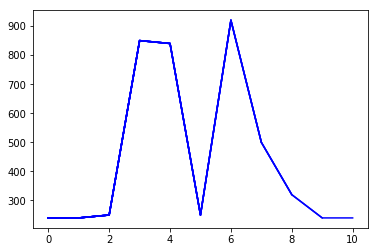

In [7]:
# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class TEST_DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = True
        self.epsilon = 0.1

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman_correctedv15.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation=None, kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam())
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
#         q_value = self.model.predict(state)
#         return np.argmax(q_value[0])
        
        
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers
import matplotlib.pyplot as plt


if __name__ == "__main__":
    EPISODES = 100
    ALL_SCORES = np.zeros(EPISODES)

    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = TEST_DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])

                state = next_state            
                score += reward
                dead = info['ale.lives']<lives
                lives = info['ale.lives']
                # if an action make the Pacman dead, then gives penalty of -100
                reward = reward if not dead else -500

            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score)
        
        ALL_SCORES[e] = score
                
    env.close()
    plt.plot(ALL_SCORES)
    plt.title("Random Agent: {} Episodes".format(EPISODES))
    plt.show()

    print("-------------------------")
    print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))